# 회귀 분석을 활용한 주택 가격 예측

In [1]:
!pip install lightgbm==3.3.5

     ---------------------------------------- 1.0/1.0 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.3.1
    Uninstalling lightgbm-2.3.1:
      Successfully uninstalled lightgbm-2.3.1



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. 라이브러리 및 데이터 불러오기

In [2]:
#평균 제곱 오차를 활용해 정확도 평가 - 로그를 취해야 예측 값 간 찿이 작아져 정확도 높아짐
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import pandas as pd
import numpy as np
import random
np.random.seed(1234) #랜덤 시드 설정
random.seed(1234)
import warnings
warnings.filterwarnings("ignore")

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. 벤치마크용 베이스라인

In [3]:
#최소한의 전처리 후 lightGBM 예측
#print(train_df.dtypes,"\n")
#print(train_df["MSZoning"].value_counts()) #판매처 용도의 분류

#학습 데이터, 테스트 데이터 합해서 전처리
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
all_df["SalePrice"] #학습 데이터는 있고, 테스트 데이터는 NaN

#카테고리 변수를 수치로 변환하기
from sklearn.preprocessing import LabelEncoder
categories = all_df.columns[all_df.dtypes=="object"]
#print(categories)
all_df["Alley"].value_counts()

#결측치를 수치로 변환하기
for cat in categories:
    le = LabelEncoder()
    #print(cat)

    all_df[cat].fillna("missing", inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


https://aldente0630.github.io/data-science/2018/06/29/highly-efficient-gbdt.html

In [4]:
#학습 데이터와 테스트 데이터로 되돌리기
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

import lightgbm as lgb #그래디언트 부스팅 결정 트리 - 4.0.0보다 낮아야 함
from sklearn.model_selection import KFold #교차 검증
folds=3
kf = KFold(n_splits=folds)
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}
#설명 변수, 목적 변수 지정
train_X = train_df_le.drop(["SalePrice", "Id"], axis=1) #설명변수
train_Y = train_df_le["SalePrice"] #목적변수

from sklearn.metrics import mean_squared_error #평균 제곱 오차
from platform import python_version

print(python_version())
#모델 별 예측값 저장하기
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    print(X_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          callbacks=[lgb.early_stopping(stopping_rounds=20),],
                          verbose_eval=10
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

3.10.7
      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
487           20        3         70.0    12243      1     2        0   
488          190        3         60.0    10800      1     2        3   
489          180        4         21.0     1526      1     2        3   
490          160        4          NaN     2665      1     2        3   
491           50        3         79.0     9490      1     2        3   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60        3         62.0     7917      1     2        3   
1456          20        3         85.0    13175      1     2        3   
1457          70        3         66.0     9042      1     2        3   
1458          20        3         68.0     9717      1     2        3   
1459          20        3         75.0     9937      1     2        3   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
487            3         0         4 

In [5]:
#평균 RMSE 계산하기
sum(rmses)/len(rmses)

0.1359164479233318

<AxesSubplot: >

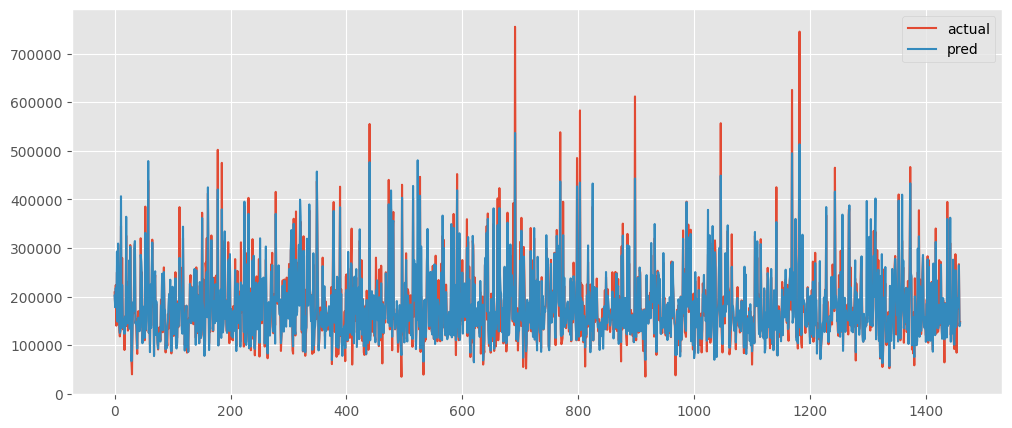

In [6]:
#현재 예측 값과 실제 값 차이 확인
actual_pred_df = pd.DataFrame({
    "actual" : train_Y,
    "pred" : oof})
actual_pred_df.plot(figsize=(12,5))

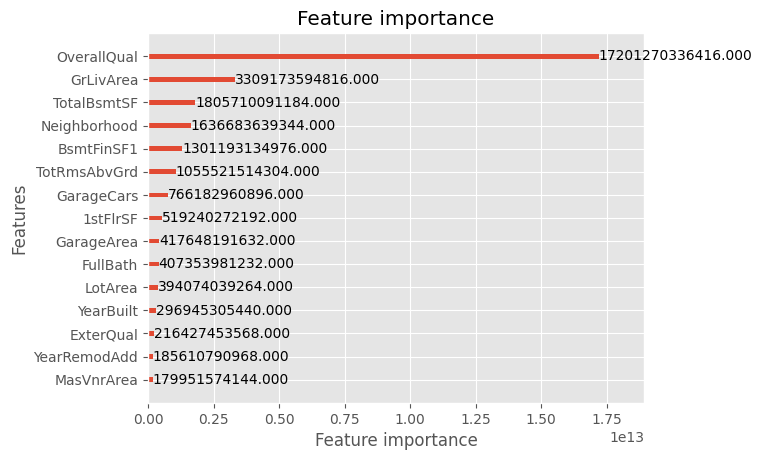

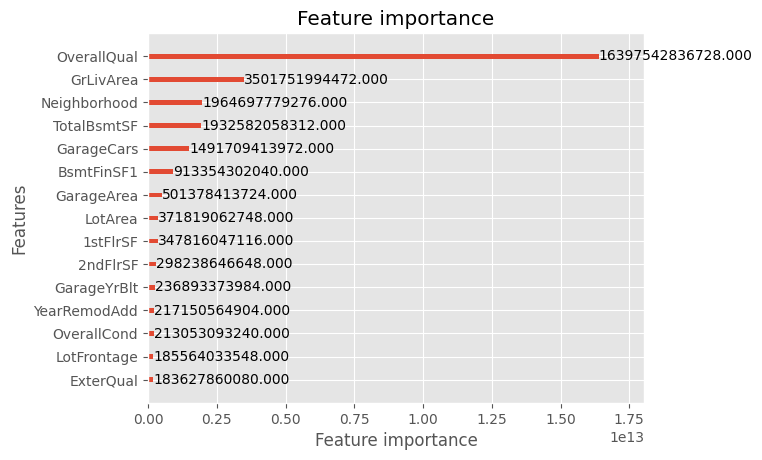

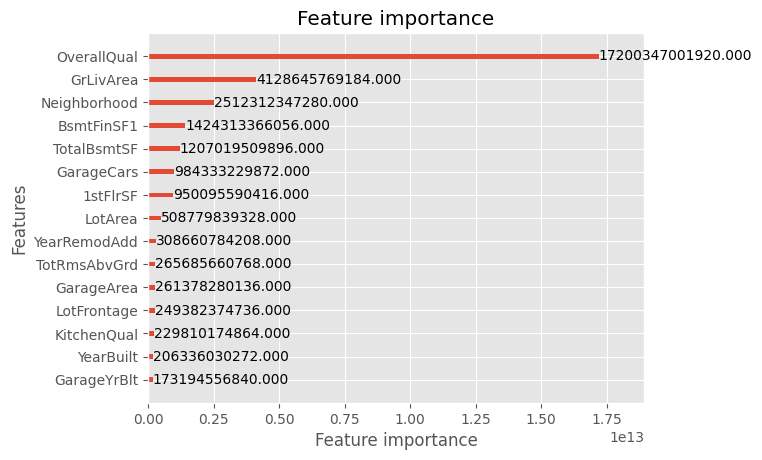

In [7]:
#각 변수의 중요도 확인 - 주택 전체의 재료와 마감 등 퀄리티, 주거 영역 크기
for model in models:
    lgb.plot_importance(model, importance_type ="gain", max_num_features=15)

## 3. 목적 변수의 전처리 : 목적 변수의 분포 확인

In [8]:
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot: ylabel='Frequency'>

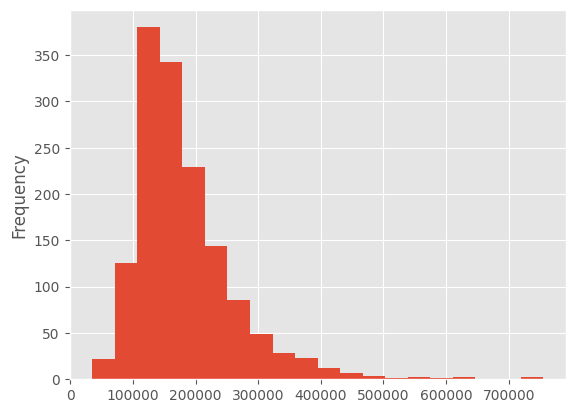

In [9]:
train_df["SalePrice"].plot.hist(bins=20) #비대칭(왼쪽으로 치우침) - 푸아송 분포

In [10]:
np.log(train_df['SalePrice'])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<AxesSubplot: ylabel='Frequency'>

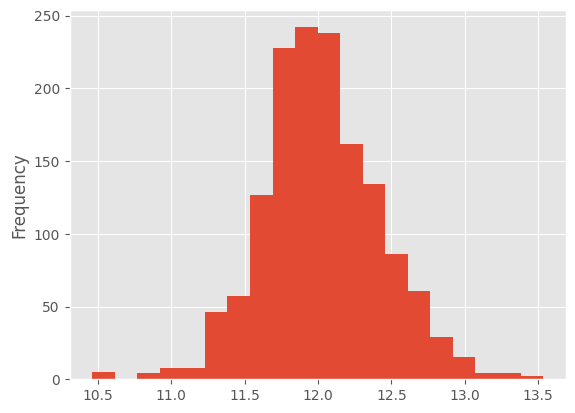

In [11]:
np.log(train_df['SalePrice']).plot.hist(bins=20) #정규분포와 비슷하게

In [12]:
pd.options.mode.chained_assignment=None #목적 변수 로그화
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [13]:
import warnings
warnings.filterwarnings("ignore")

models = []
rmses = []
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.017607
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0436707
[20]	valid_0's l2: 0.0219638
[30]	valid_0's l2: 0.0178863
[40]	valid_0's l2: 0.0168272
[50]	valid_0's l2: 0.0165421
[60]	valid_0's l2: 0.0164067
[70]	valid_0's l2: 0.0163235
[80]	valid_0's l2: 0.0162611
[90]	valid_0's l2: 0.0162673
[100]	valid_0's l2: 0.0163207
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 0.0162538
0.12749050377720023
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2985
[LightGB

In [14]:
sum(rmses)/len(rmses) #값 낮아짐 -> 즉 정확도 소폭 높아짐

0.13274830975285581

## 4. 설명 변수의 전처리 : 결측치 확인

In [15]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [16]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [17]:
all_df.isnull().sum().sort_values(ascending=False).head(40) #결측치 상위 40 변수
#고급 설비의 유무 관련 변수가 대부분 값이 없음

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
Functional          2
BsmtHalfBath        2
BsmtFullBath        2
Utilities           2
BsmtFinSF1          1
BsmtFinSF2          1
SaleType            1
Electrical          1
GarageCars          1
TotalBsmtSF         1
GarageArea          1
Exterior2nd         1
Exterior1st         1
KitchenQual         1
BsmtUnfSF           1
Fireplaces          0
TotRmsAbvGrd        0
SaleCondition       0
OpenPorchSF         0
YrSold              0
dtype: int64

In [18]:
all_df.PoolQC.value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

In [19]:
#값 있으면 1, 없으면 0으로 저장
all_df.loc[~all_df["PoolQC"].isnull(), "PoolQC"] = 1
all_df.loc[all_df["PoolQC"].isnull(), "PoolQC"] = 0

In [20]:
all_df.PoolQC.value_counts()

0    2909
1      10
Name: PoolQC, dtype: int64

In [21]:
all_df.loc[~all_df["MiscFeature"].isnull(), "MiscFeature"] = 1
all_df.loc[all_df["MiscFeature"].isnull(), "MiscFeature"] = 0
all_df.loc[~all_df["Alley"].isnull(), "Alley"] = 1
all_df.loc[all_df["Alley"].isnull(), "Alley"] = 0

In [22]:
#위의 내용 한번에 처리한 코드
'''HighFacility_col = ["PoolQC","MiscFeature","Alley"]
for col in HighFacility_col:
    if all_df[col].dtype == "object":
        if len(all_df[all_df[col].isnull()]) > 0:
            all_df.loc[~all_df[col].isnull(), col] = 1
            all_df.loc[all_df[col].isnull(), col] = 0'''

'HighFacility_col = ["PoolQC","MiscFeature","Alley"]\nfor col in HighFacility_col:\n    if all_df[col].dtype == "object":\n        if len(all_df[all_df[col].isnull()]) > 0:\n            all_df.loc[~all_df[col].isnull(), col] = 1\n            all_df.loc[all_df[col].isnull(), col] = 0'

In [23]:
#고급 설비 개수
all_df["hasHighFacility"] = all_df["PoolQC"]+all_df["MiscFeature"] + all_df["Alley"]

In [24]:
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int)

In [25]:
all_df["hasHighFacility"].value_counts()

0    2615
1     295
2       9
Name: hasHighFacility, dtype: int64

In [26]:
all_df = all_df.drop(["PoolQC","MiscFeature","Alley"],axis=1)

## 5. 이상치 제외

In [27]:
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


In [28]:
train_df_num = train_df.select_dtypes(include=[np.number]) #수치 데이터만 추출

In [29]:
#비례 척도가 아닌 변수
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]

In [30]:
#집합 자료형으로 변환해 비례 척도인 수치 데이터만 남김
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))

In [31]:
train_df_num_rs = train_df_num[num_features]

In [32]:
#다수의 데이터(75%)가 0인 변수 확인하기 (3/4분위수로 확인)
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0:
        print(col, len(train_df_num_rs[train_df_num_rs[col] == 0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


In [33]:
#특정 값만 가지는 변수 확인하기 (종류 15개 미만)
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col, train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12


In [34]:
#이상치 확인 -> 평균 +- 3*표준편차
for col in num_features:
    tmp_df = train_df_num_rs[(train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std()*3) | \
    (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std()*3)]
    print(col, len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


<AxesSubplot: xlabel='BsmtFinSF1', ylabel='SalePrice'>

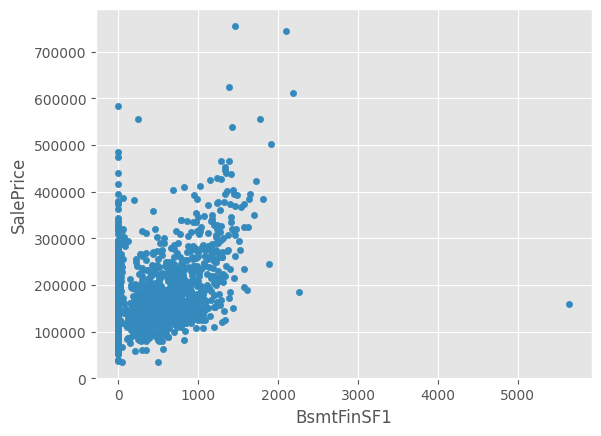

In [35]:
#이상치를 포함하는 변수의 분포 시각화
all_df.plot.scatter(x="BsmtFinSF1", y="SalePrice")

In [36]:
all_df[all_df["BsmtFinSF1"]>5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<AxesSubplot: xlabel='TotalBsmtSF', ylabel='SalePrice'>

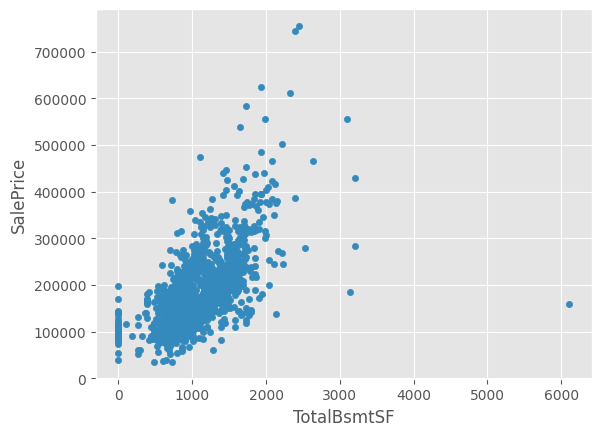

In [37]:
all_df.plot.scatter(x="TotalBsmtSF", y="SalePrice")

In [38]:
all_df[all_df["TotalBsmtSF"] > 6000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<AxesSubplot: xlabel='GrLivArea', ylabel='SalePrice'>

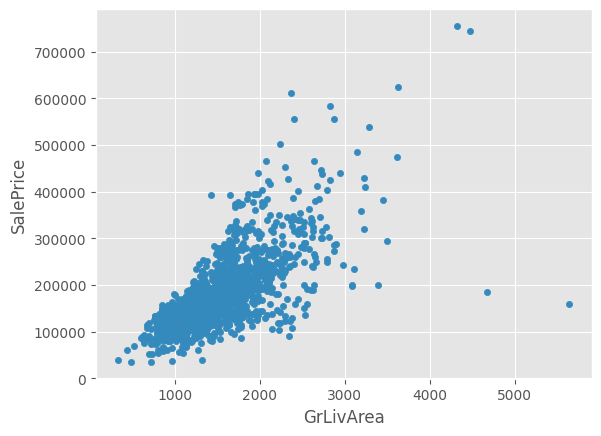

In [39]:
all_df.plot.scatter(x="GrLivArea", y="SalePrice")

In [40]:
all_df[all_df["GrLivArea"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


<AxesSubplot: xlabel='1stFlrSF', ylabel='SalePrice'>

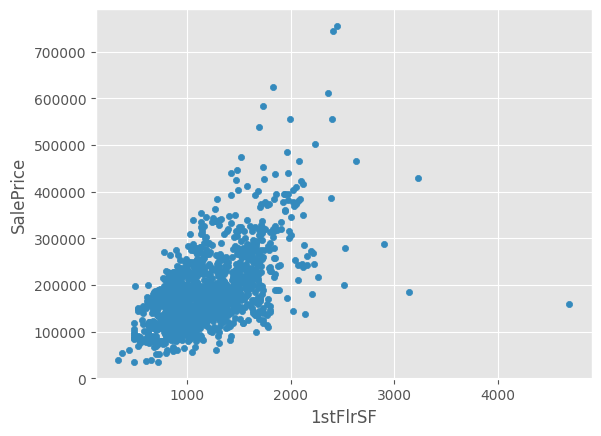

In [41]:
all_df.plot.scatter(x="1stFlrSF", y="SalePrice")

In [42]:
all_df[all_df["1stFlrSF"] > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


In [43]:
#이상치가 아닌 값 추출하기
all_df = all_df[(all_df['BsmtFinSF1'] < 2000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['TotalBsmtSF'] < 3000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['GrLivArea'] < 4500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['1stFlrSF'] < 2500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['LotArea'] < 100000) | (all_df['SalePrice'].isnull())]

In [44]:
categories = categories.drop(["PoolQC","MiscFeature","Alley"])

In [45]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True)    
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


In [46]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"]) #로그 변환
train_X = train_df_le.drop(["SalePrice","SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [47]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2949
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0423077
[20]	valid_0's l2: 0.0220026
[30]	valid_0's l2: 0.0175682
[40]	valid_0's l2: 0.0163798
[50]	valid_0's l2: 0.0162547
[60]	valid_0's l2: 0.0162622
[70]	valid_0's l2: 0.0162514
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0161791
0.12719701309461987
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2943
[LightGBM] [Info] Number of data points in th

In [48]:
sum(rmses)/len(rmses) #정확도 소폭 향상

0.1298064868429131

## 6. 설명 변수 확인 : 특징 값 생성

In [49]:
#시간 데이터, 넓이 데이터, 설비 및 허용 수 데이터, 품질 및 분류 데이터 등
all_df[["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold"]].describe() #시간 데이터

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2904.000000,2904.000000,2745.000000,2904.000000
mean,1971.234504,1984.217975,1978.061202,2007.792011
std,30.319059,20.907346,25.600996,1.316366
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [50]:
#건축 후 몇 년이 경과했을 때 판매되었는지
all_df["Age"] = all_df["YrSold"] - all_df["YearBuilt"]

In [51]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [52]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3046
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 73
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.042401
[20]	valid_0's l2: 0.0217498
[30]	valid_0's l2: 0.0175187
[40]	valid_0's l2: 0.0162941
[50]	valid_0's l2: 0.0160985
[60]	valid_0's l2: 0.0160802
[70]	valid_0's l2: 0.0161142
[80]	valid_0's l2: 0.016149
Early stopping, best iteration is:
[68]	valid_0's l2: 0.0160466
0.1266752634099996
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

In [53]:
sum(rmses)/len(rmses) #정확도 소폭 상승

0.12939563041691993

In [54]:
#넓이에 관한 변수 
all_df[["LotArea","MasVnrArea","BsmtUnfSF","TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea","WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "LotFrontage"]].describe()

,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,LotFrontage
count,2904.000000,2882.000000,2903.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2425.000000
mean,9912.604683,101.191187,559.850499,1043.794006,1152.707300,336.355372,4.718664,1493.781336,471.632794,93.265840,47.226584,22.988636,2.615702,16.086777,1.907025,69.071340
std,5178.128224,177.804595,438.438879,420.008348,377.291394,427.355787,46.515308,491.149725,214.551791,125.855568,67.195477,64.055325,25.252464,56.245764,33.082892,22.662001
min,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,7448.250000,0.000000,220.000000,791.500000,875.750000,0.000000,0.000000,1124.000000,319.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000
50%,9422.000000,0.000000,467.000000,988.000000,1080.000000,0.000000,0.000000,1441.000000,478.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,68.000000
75%,11503.000000,164.000000,802.500000,1296.000000,1381.250000,704.000000,0.000000,1739.250000,576.000000,168.000000,69.250000,0.000000,0.000000,0.000000,0.000000,80.000000
max,70761.000000,1600.000000,2336.000000,5095.000000,5095.000000,1872.000000,1064.000000,5095.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,313.000000


In [55]:
#각 층의 전체 넓이 + 욕실 수 의 합계
all_df["TotalSF"] = all_df["TotalBsmtSF"] + all_df["1stFlrSF"] + all_df["2ndFlrSF"]
all_df["Total_Bathrooms"] = all_df["FullBath"] + all_df["HalfBath"] + all_df["BsmtFullBath"] + all_df["BsmtHalfBath"]

In [56]:
#Porch 넓이의 합계(차 대는 곳)
all_df["Total_PorchSF"] = all_df["WoodDeckSF"] + all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + all_df["3SsnPorch"] + all_df["ScreenPorch"]

In [57]:
#Porch 있는지 없는지 확인
all_df["hasPorch"] = all_df["Total_PorchSF"].apply(lambda x: 1 if x > 0 else 0)
all_df = all_df.drop("Total_PorchSF",axis=1)

In [58]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [59]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3310
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0382198
[20]	valid_0's l2: 0.0195098
[30]	valid_0's l2: 0.0163133
[40]	valid_0's l2: 0.0155157
[50]	valid_0's l2: 0.0154576
[60]	valid_0's l2: 0.0155145
Early stopping, best iteration is:
[48]	valid_0's l2: 0.0154265
0.12420330159076388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3300
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.

In [60]:
sum(rmses)/len(rmses) #정확도 소폭 상승

0.127159916020503

## 7. 하이퍼파라미터 최적화

In [61]:
!pip install optuna==2.0.0

     -------------------------------------- 226.9/226.9 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 226.8/226.8 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 80.6/80.6 kB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 8.7 MB/s eta 0:00:00
     -------------------------------------- 287.9/287.9 kB 5.9 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.6 MB/s eta 0:00:00
     -------------------------------------- 147.2/147.2 kB 8.6 MB/s eta 0:00:00
     ---------------------------------------- 49.6/49.6 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 95.2/95.2 kB 2.7 MB/s eta 0:00:00
     -------------------------------------- 112.7/112.7 kB 3.3 MB/s eta 0:00:00
  Created wheel for optuna: filename=optuna-2.0.0-py3-none-any.whl size=312822 sha256=1cf530fbea4240


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
#하이퍼파라미터 최적화 - Optuna
#1. 모델의 학습 흐름과 개선하려는 정확도 정의
#2. 조정하고자 하는 모델의 하이퍼파라미터 및 탐색 범위 설정
#3. 실행 횟수 정하여 최적화 실행
import optuna
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False,  stratify=None)

In [64]:
def objective(trial):
    params = {
        "objective":"regression",
        "random_seed":1234,
        "learning_rate":0.05, #앞서 실행한 학습을 다음 학습에 반영할 비율       
        "n_estimators":1000,  #학습 횟수
        #최적화할 하이퍼파라미터
        "num_leaves":trial.suggest_int("num_leaves",4,64),
        "max_bin":trial.suggest_int("max_bin",50,200),        
        "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
        "bagging_freq":trial.suggest_int("bagging_freq",1,10),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf",2,16),                
        "min_sum_hessian_in_leaf":trial.suggest_int("min_sum_hessian_in_leaf",1,10),
    }
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(params, lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,)    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score =  np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return score

In [65]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

[I 2023-10-27 21:02:17,749] Trial 0 finished with value: 0.1198447794841605 and parameters: {'num_leaves': 48, 'max_bin': 97, 'bagging_fraction': 0.7575946831862097, 'bagging_freq': 4, 'feature_fraction': 0.8289728088113784, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.1198447794841605.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0643147
[20]	valid_0's l2: 0.0342746
[30]	valid_0's l2: 0.0227327
[40]	valid_0's l2: 0.0180827
[50]	valid_0's l2: 0.0158105
[60]	valid_0's l2: 0.0149719
[70]	valid_0's l2: 0.0147425
[80]	valid_0's l2: 0.0145246
[90]	valid_0's l2: 0.0144525
[100]	valid_0's l2: 0.0144044
[110]	valid_0's l2: 0.0144097
[120]	valid_0's l2: 0.0144603
Early stopping, best iteration is:
[101]	valid_0's l2: 0.0143628
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

[I 2023-10-27 21:02:17,869] Trial 1 finished with value: 0.11821414461590443 and parameters: {'num_leaves': 23, 'max_bin': 71, 'bagging_fraction': 0.5921908536463499, 'bagging_freq': 8, 'feature_fraction': 0.8458865003910399, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 1 with value: 0.11821414461590443.


[80]	valid_0's l2: 0.0146608
[90]	valid_0's l2: 0.0143546
[100]	valid_0's l2: 0.014117
[110]	valid_0's l2: 0.0141155
[120]	valid_0's l2: 0.0139746
[130]	valid_0's l2: 0.0140222
[140]	valid_0's l2: 0.0140586
Early stopping, best iteration is:
[120]	valid_0's l2: 0.0139746
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1971
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0651071
[20]	valid_0's l2: 0.0360684
[30]	valid_0's l2: 0.0237207
[40]	valid_0's l2: 0.0183713
[50]	valid_0's l2: 0.0160427
[60]	valid_0's l2: 0.0149609
[70]	valid_0's l2: 0.0144555
[80]	valid_0's l2: 0.0140841
[90]	valid_0's l2: 0.0140441
[100]	valid_0's l2: 0.0139169
[110]	valid_0's l2: 0.0135834
[

[I 2023-10-27 21:02:18,014] Trial 2 finished with value: 0.11629686523123912 and parameters: {'num_leaves': 42, 'max_bin': 89, 'bagging_fraction': 0.6644474598764523, 'bagging_freq': 9, 'feature_fraction': 0.5963923980504149, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 2 with value: 0.11629686523123912.
[I 2023-10-27 21:02:18,125] Trial 3 finished with value: 0.12754641603157274 and parameters: {'num_leaves': 13, 'max_bin': 198, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 4, 'feature_fraction': 0.8785775794765232, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 2 with value: 0.11629686523123912.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3125
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0704305
[20]	valid_0's l2: 0.0405597
[30]	valid_0's l2: 0.0282192
[40]	valid_0's l2: 0.0225395
[50]	valid_0's l2: 0.0196973
[60]	valid_0's l2: 0.0182368
[70]	valid_0's l2: 0.017668
[80]	valid_0's l2: 0.0169726
[90]	valid_0's l2: 0.0169463
[100]	valid_0's l2: 0.0167922
[110]	valid_0's l2: 0.0166246
[120]	valid_0's l2: 0.0165132
[130]	valid_0's l2: 0.0163901
[140]	valid_0's l2: 0.0162681
[150]	valid_0's l2: 0.0165408
[160]	valid_0's l2: 0.0165676
Early stopping, best iteration is:
[140]	valid_0's l2: 0.0162681
[LightGBM] [Warning] Auto-choosing col-wise multi-threading

[I 2023-10-27 21:02:18,264] Trial 4 finished with value: 0.12178023323876243 and parameters: {'num_leaves': 39, 'max_bin': 79, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 8, 'feature_fraction': 0.7199605106637619, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 2 with value: 0.11629686523123912.
[I 2023-10-27 21:02:18,368] Trial 5 finished with value: 0.1196701093671995 and parameters: {'num_leaves': 36, 'max_bin': 81, 'bagging_fraction': 0.4529538035938961, 'bagging_freq': 8, 'feature_fraction': 0.5322778060523135, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 3}. Best is trial 2 with value: 0.11629686523123912.


[90]	valid_0's l2: 0.014974
[100]	valid_0's l2: 0.0149333
Early stopping, best iteration is:
[80]	valid_0's l2: 0.0148304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[I 2023-10-27 21:02:18,580] Trial 6 finished with value: 0.118816626260781 and parameters: {'num_leaves': 59, 'max_bin': 78, 'bagging_fraction': 0.6842169744343243, 'bagging_freq': 1, 'feature_fraction': 0.5620705038966071, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 7}. Best is trial 2 with value: 0.11629686523123912.


[60]	valid_0's l2: 0.0151231
[70]	valid_0's l2: 0.0145094
[80]	valid_0's l2: 0.014275
[90]	valid_0's l2: 0.0142642
[100]	valid_0's l2: 0.0142771
[110]	valid_0's l2: 0.0142122
[120]	valid_0's l2: 0.0141649
[130]	valid_0's l2: 0.0141662
[140]	valid_0's l2: 0.0141355
[150]	valid_0's l2: 0.0141642
Early stopping, best iteration is:
[133]	valid_0's l2: 0.0141174
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0653357
[20]	valid_0's l2: 0.0354284
[30]	valid_0's l2: 0.0236228
[40]	valid_0's l2: 0.0189468
[50]	valid_0's l2: 0.016896
[60]	valid_0's l2: 0.0160145


[I 2023-10-27 21:02:18,789] Trial 7 finished with value: 0.12238115552900761 and parameters: {'num_leaves': 44, 'max_bin': 67, 'bagging_fraction': 0.8718740392573121, 'bagging_freq': 10, 'feature_fraction': 0.6249749949556138, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 2 with value: 0.11629686523123912.


[70]	valid_0's l2: 0.015712
[80]	valid_0's l2: 0.0154868
[90]	valid_0's l2: 0.0153602
[100]	valid_0's l2: 0.0153142
[110]	valid_0's l2: 0.0152365
[120]	valid_0's l2: 0.0151932
[130]	valid_0's l2: 0.01508
[140]	valid_0's l2: 0.0151574
[150]	valid_0's l2: 0.0150417
[160]	valid_0's l2: 0.014998
[170]	valid_0's l2: 0.015025
Early stopping, best iteration is:
[156]	valid_0's l2: 0.0149771
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.078175
[20]	valid_0's l2: 0.0491921
[30]	valid_0's l2: 0.0348321
[40]	valid_0's l2: 0.0273897
[50]	valid_0's l2: 0.0231761

[I 2023-10-27 21:02:18,951] Trial 8 finished with value: 0.12015491843877232 and parameters: {'num_leaves': 5, 'max_bin': 107, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 8, 'feature_fraction': 0.4854547925680226, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 2 with value: 0.11629686523123912.


[160]	valid_0's l2: 0.0153281
[170]	valid_0's l2: 0.0152202
[180]	valid_0's l2: 0.0151828
[190]	valid_0's l2: 0.0150164
[200]	valid_0's l2: 0.0149845
[210]	valid_0's l2: 0.0149025
[220]	valid_0's l2: 0.0147877
[230]	valid_0's l2: 0.01473
[240]	valid_0's l2: 0.0146358
[250]	valid_0's l2: 0.014534
[260]	valid_0's l2: 0.0145214
[270]	valid_0's l2: 0.0144804
[280]	valid_0's l2: 0.0144955
[290]	valid_0's l2: 0.0144664
[300]	valid_0's l2: 0.0145545
Early stopping, best iteration is:
[285]	valid_0's l2: 0.0144372
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2710
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2:

[I 2023-10-27 21:02:19,098] Trial 9 finished with value: 0.11741508223363016 and parameters: {'num_leaves': 18, 'max_bin': 149, 'bagging_fraction': 0.5818553854713113, 'bagging_freq': 10, 'feature_fraction': 0.4192127132363674, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 2 with value: 0.11629686523123912.
[I 2023-10-27 21:02:19,204] Trial 10 finished with value: 0.1235774011359613 and parameters: {'num_leaves': 10, 'max_bin': 97, 'bagging_fraction': 0.5044383780474173, 'bagging_freq': 4, 'feature_fraction': 0.8976497838389439, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 2 with value: 0.11629686523123912.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0725023
[20]	valid_0's l2: 0.0434443
[30]	valid_0's l2: 0.0298761
[40]	valid_0's l2: 0.0238304
[50]	valid_0's l2: 0.0203224
[60]	valid_0's l2: 0.0183536
[70]	valid_0's l2: 0.0174563
[80]	valid_0's l2: 0.016562
[90]	valid_0's l2: 0.0163574
[100]	valid_0's l2: 0.0159202
[110]	valid_0's l2: 0.015703
[120]	valid_0's l2: 0.0155166
[130]	valid_0's l2: 0.0154357
[140]	valid_0's l2: 0.0153155
[150]	valid_0's l2: 0.0153036
[160]	valid_0's l2: 0.0152859
Early stopping, best iteration is:
[142]	valid_0's l2: 0.0152

[I 2023-10-27 21:02:19,349] Trial 11 finished with value: 0.11618132607404374 and parameters: {'num_leaves': 18, 'max_bin': 193, 'bagging_fraction': 0.6373487511442064, 'bagging_freq': 8, 'feature_fraction': 0.5690038074194459, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.11618132607404374.


[140]	valid_0's l2: 0.0135158
[150]	valid_0's l2: 0.0135428
[160]	valid_0's l2: 0.0135941
Early stopping, best iteration is:
[143]	valid_0's l2: 0.0134981
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2116
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0656405
[20]	valid_0's l2: 0.0353302
[30]	valid_0's l2: 0.023382
[40]	valid_0's l2: 0.0186146
[50]	valid_0's l2: 0.0164558
[60]	valid_0's l2: 0.0154582
[70]	valid_0's l2: 0.0149818
[80]	valid_0's l2: 0.0146487
[90]	valid_0's l2: 0.0145092
[100]	valid_0's l2: 0.0144146
[110]	valid_0's l2: 0.0142623
[120]	valid_0's l2: 0.0143103
Early stopping, best iteration is:
[109]	valid_0's l2: 0.01426


[I 2023-10-27 21:02:19,513] Trial 12 finished with value: 0.11941536585850102 and parameters: {'num_leaves': 52, 'max_bin': 99, 'bagging_fraction': 0.7891727410129545, 'bagging_freq': 4, 'feature_fraction': 0.5843625853304821, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:19,619] Trial 13 finished with value: 0.120307896998986 and parameters: {'num_leaves': 53, 'max_bin': 86, 'bagging_fraction': 0.44804920394698156, 'bagging_freq': 4, 'feature_fraction': 0.6343256008238508, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-10-27 21:02:19,767] Trial 14 finished with value: 0.11965588676178573 and parameters: {'num_leaves': 43, 'max_bin': 199, 'bagging_fraction': 0.7696317896991509, 'bagging_freq': 1, 'feature_fraction': 0.6208554606244228, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.11618132607404374.


[80]	valid_0's l2: 0.0145798
[90]	valid_0's l2: 0.0144004
[100]	valid_0's l2: 0.0143463
[110]	valid_0's l2: 0.0143831
Early stopping, best iteration is:
[98]	valid_0's l2: 0.0143175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0634593
[20]	valid_0's l2: 0.0337502
[30]	valid_0's l2: 0.0223666
[40]	valid_0's l2: 0.0184618
[50]	valid_0's l2: 0.0166105
[60]	valid_0's l2: 0.015806
[70]	valid_0's l2: 0.0156011
[80]	valid_0's l2: 0.0153259
[90]	valid_0's l2: 0.0152913


[I 2023-10-27 21:02:20,042] Trial 15 finished with value: 0.12284345640809934 and parameters: {'num_leaves': 63, 'max_bin': 180, 'bagging_fraction': 0.7443305914028853, 'bagging_freq': 4, 'feature_fraction': 0.8591177331810724, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 11 with value: 0.11618132607404374.


[100]	valid_0's l2: 0.0152916
[110]	valid_0's l2: 0.0152535
[120]	valid_0's l2: 0.0152364
[130]	valid_0's l2: 0.015202
[140]	valid_0's l2: 0.0151249
[150]	valid_0's l2: 0.015118
[160]	valid_0's l2: 0.0151606
Early stopping, best iteration is:
[144]	valid_0's l2: 0.0150905
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0662203
[20]	valid_0's l2: 0.0370518
[30]	valid_0's l2: 0.0250162
[40]	valid_0's l2: 0.0205021
[50]	valid_0's l2: 0.0181858
[60]	valid_0's l2: 0.0165673
[70]	valid_0's l2: 0.0159432
[80]	valid_0's l2: 0.0158693
[90]	valid_0's l2: 0.0157

[I 2023-10-27 21:02:20,196] Trial 16 finished with value: 0.1252571689635817 and parameters: {'num_leaves': 50, 'max_bin': 198, 'bagging_fraction': 0.5326947454697227, 'bagging_freq': 10, 'feature_fraction': 0.8605788051185999, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:20,341] Trial 17 finished with value: 0.12143571378187983 and parameters: {'num_leaves': 47, 'max_bin': 154, 'bagging_fraction': 0.7337051899818409, 'bagging_freq': 4, 'feature_fraction': 0.7235870700937778, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 11 with value: 0.11618132607404374.


[100]	valid_0's l2: 0.0156902
[110]	valid_0's l2: 0.015934
Early stopping, best iteration is:
[99]	valid_0's l2: 0.0156894
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2768
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0654216
[20]	valid_0's l2: 0.0349807
[30]	valid_0's l2: 0.0228376
[40]	valid_0's l2: 0.0183475
[50]	valid_0's l2: 0.0163044
[60]	valid_0's l2: 0.0153727
[70]	valid_0's l2: 0.0150899
[80]	valid_0's l2: 0.0148454
[90]	valid_0's l2: 0.0148139
[100]	valid_0's l2: 0.0147871
[110]	valid_0's l2: 0.0147883
Early stopping, best iteration is:
[98]	valid_0's l2: 0.0147466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing w

[I 2023-10-27 21:02:20,467] Trial 18 finished with value: 0.11963115132047644 and parameters: {'num_leaves': 42, 'max_bin': 69, 'bagging_fraction': 0.5989103763793145, 'bagging_freq': 4, 'feature_fraction': 0.4100537730937468, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 11 with value: 0.11618132607404374.


[20]	valid_0's l2: 0.0379604
[30]	valid_0's l2: 0.0253836
[40]	valid_0's l2: 0.0195699
[50]	valid_0's l2: 0.0168675
[60]	valid_0's l2: 0.0156431
[70]	valid_0's l2: 0.0148649
[80]	valid_0's l2: 0.0145067
[90]	valid_0's l2: 0.0145007
[100]	valid_0's l2: 0.0144626
[110]	valid_0's l2: 0.0143276
[120]	valid_0's l2: 0.0143515
Early stopping, best iteration is:
[108]	valid_0's l2: 0.0143116
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1396
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0764353
[20]	valid_0's l2: 0.0461274
[30]	valid_0's l2: 0.0320078
[40]	valid_0's l2: 0.0248053
[50]	valid_0's l2: 0.021319

[I 2023-10-27 21:02:20,578] Trial 19 finished with value: 0.11621399521606993 and parameters: {'num_leaves': 6, 'max_bin': 53, 'bagging_fraction': 0.7518686396449581, 'bagging_freq': 1, 'feature_fraction': 0.5243765717599791, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:20,737] Trial 20 finished with value: 0.12054402224983903 and parameters: {'num_leaves': 30, 'max_bin': 117, 'bagging_fraction': 0.8763745057584925, 'bagging_freq': 1, 'feature_fraction': 0.8232043362355639, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2328
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.065892
[20]	valid_0's l2: 0.0364247
[30]	valid_0's l2: 0.0243312
[40]	valid_0's l2: 0.0194631
[50]	valid_0's l2: 0.0172652
[60]	valid_0's l2: 0.01631
[70]	valid_0's l2: 0.0155683
[80]	valid_0's l2: 0.0151806
[90]	valid_0's l2: 0.0149874
[100]	valid_0's l2: 0.0147209
[110]	valid_0's l2: 0.0147372
[120]	valid_0's l2: 0.0146624
[130]	valid_0's l2: 0.0146876
[140]	valid_0's l2: 0.0145701
[150]	valid_0's l2: 0.0145861
[160]	valid_0's l2: 0.0145771
Early stopping, best iteration is:
[142]	valid_0's l2: 0.0145309
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[I 2023-10-27 21:02:20,857] Trial 21 finished with value: 0.11850220621768544 and parameters: {'num_leaves': 17, 'max_bin': 171, 'bagging_fraction': 0.5982528704234924, 'bagging_freq': 9, 'feature_fraction': 0.5248981378274891, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.11618132607404374.


[10]	valid_0's l2: 0.0687222
[20]	valid_0's l2: 0.0396098
[30]	valid_0's l2: 0.0270036
[40]	valid_0's l2: 0.0209714
[50]	valid_0's l2: 0.0179048
[60]	valid_0's l2: 0.0162111
[70]	valid_0's l2: 0.0152801
[80]	valid_0's l2: 0.014858
[90]	valid_0's l2: 0.0144057
[100]	valid_0's l2: 0.0143441
[110]	valid_0's l2: 0.0141481
[120]	valid_0's l2: 0.0140986
[130]	valid_0's l2: 0.0141318
Early stopping, best iteration is:
[117]	valid_0's l2: 0.0140428
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-10-27 21:02:20,994] Trial 22 finished with value: 0.11981100537843725 and parameters: {'num_leaves': 50, 'max_bin': 75, 'bagging_fraction': 0.6942325425343747, 'bagging_freq': 10, 'feature_fraction': 0.6506621909633512, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:21,121] Trial 23 finished with value: 0.12074148089864017 and parameters: {'num_leaves': 37, 'max_bin': 154, 'bagging_fraction': 0.6119275242790898, 'bagging_freq': 10, 'feature_fraction': 0.6350660946278825, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's l2: 0.0146218
Early stopping, best iteration is:
[120]	valid_0's l2: 0.0143547
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2768
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with po

[I 2023-10-27 21:02:21,300] Trial 24 finished with value: 0.12082733613431533 and parameters: {'num_leaves': 60, 'max_bin': 129, 'bagging_fraction': 0.7745849185763624, 'bagging_freq': 9, 'feature_fraction': 0.46773703211122514, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's l2: 0.0192768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-10-27 21:02:21,452] Trial 25 finished with value: 0.11852927117025001 and parameters: {'num_leaves': 51, 'max_bin': 143, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 7, 'feature_fraction': 0.7266004099285668, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:21,530] Trial 26 finished with value: 0.12331302276330075 and parameters: {'num_leaves': 7, 'max_bin': 53, 'bagging_fraction': 0.5837809350239482, 'bagging_freq': 7, 'feature_fraction': 0.8920211206820732, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's l2: 0.0143519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-10-27 21:02:21,645] Trial 27 finished with value: 0.1194747033754345 and parameters: {'num_leaves': 27, 'max_bin': 93, 'bagging_fraction': 0.4501134436561506, 'bagging_freq': 9, 'feature_fraction': 0.5761558306002665, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:21,758] Trial 28 finished with value: 0.11704159919839867 and parameters: {'num_leaves': 32, 'max_bin': 161, 'bagging_fraction': 0.41877969191407016, 'bagging_freq': 4, 'feature_fraction': 0.48342375652424985, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 11 with value: 0.11618132607404374.


[80]	valid_0's l2: 0.0146766
[90]	valid_0's l2: 0.0145014
[100]	valid_0's l2: 0.0144947
[110]	valid_0's l2: 0.0143046
[120]	valid_0's l2: 0.0143474
[130]	valid_0's l2: 0.0145355
Early stopping, best iteration is:
[117]	valid_0's l2: 0.0142742
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0672843
[20]	valid_0's l2: 0.0370306
[30]	valid_0's l2: 0.0249506
[40]	valid_0's l2: 0.0197243
[50]	valid_0's l2: 0.0169298
[60]	valid_0's l2: 0.0152988
[70]	valid_0's l2: 0.0145359
[80]	valid_0's l2: 0.0138849
[90]	valid_0's l2: 0.0138649
[100]	valid_0's l2: 0.0137877
Early stopping, best iteration is:
[86]	valid_0's l2: 0.0136

[I 2023-10-27 21:02:21,929] Trial 29 finished with value: 0.12093121467429153 and parameters: {'num_leaves': 50, 'max_bin': 198, 'bagging_fraction': 0.6056983618777273, 'bagging_freq': 4, 'feature_fraction': 0.6035916486129999, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 11 with value: 0.11618132607404374.


[30]	valid_0's l2: 0.0245746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's l2: 0.0191318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's l2: 0.0167009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's l2: 0.0155083
[LightGBM] [Warning] No further splits with positive gain, 

[I 2023-10-27 21:02:22,095] Trial 30 finished with value: 0.12103336420215649 and parameters: {'num_leaves': 45, 'max_bin': 181, 'bagging_fraction': 0.6100376848953053, 'bagging_freq': 3, 'feature_fraction': 0.8331911629643146, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.11618132607404374.


[90]	valid_0's l2: 0.0150656
[100]	valid_0's l2: 0.014867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's l2: 0.0146688
[120]	valid_0's l2: 0.0147799
Early stopping, best iteration is:
[109]	valid_0's l2: 0.0146491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0643704
[20]	valid_0's l2: 0.0347741
[30]	valid_0's l2: 0.0234035
[40]	valid_0's l2: 0.0186227
[50]	valid_0's l2: 0.0167138
[60]	valid_0's l2: 0.0158867
[70]	valid_0's l2: 0.0156593
[80]	valid_0's l2: 0.0156101
[90]	valid_0's l2: 0.015592
Early stopping, best iteration is:
[78]	valid_0's l2: 0.0155048


[I 2023-10-27 21:02:22,236] Trial 31 finished with value: 0.12451844259872365 and parameters: {'num_leaves': 43, 'max_bin': 111, 'bagging_fraction': 0.7649952812120291, 'bagging_freq': 3, 'feature_fraction': 0.6605183031020647, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:22,415] Trial 32 finished with value: 0.12295202632742118 and parameters: {'num_leaves': 44, 'max_bin': 86, 'bagging_fraction': 0.48549329934156576, 'bagging_freq': 3, 'feature_fraction': 0.5119623440301901, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0676051
[20]	valid_0's l2: 0.0370919
[30]	valid_0's l2: 0.0248415
[40]	valid_0's l2: 0.0196148
[50]	valid_0's l2: 0.0171186
[60]	valid_0's l2: 0.0159918
[70]	valid_0's l2: 0.01563
[80]	valid_0's l2: 0.0154027
[90]	valid_0's l2: 0.0154689
[100]	valid_0's l2: 0.0153742
[110]	valid_0's l2: 0.015284
[120]	valid_0's l2: 0.0151469
[130]	valid_0's l2: 0.0151767
[140]	valid_0's l2: 0.0151742
[150]	valid_0's l2: 0.0152882
Early stopping, best iteration is:
[133]	valid_0's l2: 0.0151172
[LightGBM] [Warning] Auto-c

[I 2023-10-27 21:02:22,540] Trial 33 finished with value: 0.11872456858948927 and parameters: {'num_leaves': 12, 'max_bin': 179, 'bagging_fraction': 0.7918221226509443, 'bagging_freq': 4, 'feature_fraction': 0.7107392007498818, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 11 with value: 0.11618132607404374.


[60]	valid_0's l2: 0.0167027
[70]	valid_0's l2: 0.015894
[80]	valid_0's l2: 0.0154418
[90]	valid_0's l2: 0.0150668
[100]	valid_0's l2: 0.0148548
[110]	valid_0's l2: 0.0147066
[120]	valid_0's l2: 0.0145342
[130]	valid_0's l2: 0.0143857
[140]	valid_0's l2: 0.0141905
[150]	valid_0's l2: 0.0141653
[160]	valid_0's l2: 0.0141678
[170]	valid_0's l2: 0.0140955
[180]	valid_0's l2: 0.0142089
[190]	valid_0's l2: 0.0142349
Early stopping, best iteration is:
[170]	valid_0's l2: 0.0140955
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits 

[I 2023-10-27 21:02:22,693] Trial 34 finished with value: 0.11781170981426635 and parameters: {'num_leaves': 40, 'max_bin': 75, 'bagging_fraction': 0.5336312689407392, 'bagging_freq': 4, 'feature_fraction': 0.8321407213431223, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's l2: 0.0139364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2023-10-27 21:02:22,930] Trial 35 finished with value: 0.12034699554714853 and parameters: {'num_leaves': 37, 'max_bin': 196, 'bagging_fraction': 0.6771212175422201, 'bagging_freq': 5, 'feature_fraction': 0.5049218744875611, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:23,039] Trial 36 finished with value: 0.12323038570690424 and parameters: {'num_leaves': 16, 'max_bin': 94, 'bagging_fraction': 0.7697753975246437, 'bagging_freq': 3, 'feature_fraction': 0.8851183415480504, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.11618132607404374.


[170]	valid_0's l2: 0.0145155
[180]	valid_0's l2: 0.0145008
[190]	valid_0's l2: 0.0145412
Early stopping, best iteration is:
[176]	valid_0's l2: 0.0144834
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0688794
[20]	valid_0's l2: 0.0392416
[30]	valid_0's l2: 0.0264653
[40]	valid_0's l2: 0.0208299
[50]	valid_0's l2: 0.0182412
[60]	valid_0's l2: 0.0168096
[70]	valid_0's l2: 0.0162385
[80]	valid_0's l2: 0.0158175
[90]	valid_0's l2: 0.0156793
[100]	valid_0's l2: 0.0155696
[110]	valid_0's l2: 0.015333
[120]	valid_0's l2: 0.0152713
[130]	valid_0's l2: 0.0152821
[140]	valid_0's l2: 0.0152505
Early stopping, best iteratio

[I 2023-10-27 21:02:23,158] Trial 37 finished with value: 0.1255065715241707 and parameters: {'num_leaves': 43, 'max_bin': 200, 'bagging_fraction': 0.6172083127790604, 'bagging_freq': 7, 'feature_fraction': 0.8405022811008375, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 4}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's l2: 0.0174954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's l2: 0.0166975
[LightGBM] [Warning] No further splits wit

[I 2023-10-27 21:02:23,348] Trial 38 finished with value: 0.12180980263626547 and parameters: {'num_leaves': 53, 'max_bin': 91, 'bagging_fraction': 0.41233936419566564, 'bagging_freq': 6, 'feature_fraction': 0.771917272654894, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 11 with value: 0.11618132607404374.


[120]	valid_0's l2: 0.0149414
[130]	valid_0's l2: 0.0149362
[140]	valid_0's l2: 0.014845
[150]	valid_0's l2: 0.0150009
Early stopping, best iteration is:
[139]	valid_0's l2: 0.0148376
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2404
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.066698
[20]	valid_0's l2: 0.0372566
[30]	valid_0's l2: 0.0250946
[40]	valid_0's l2: 0.0199272
[50]	valid_0's l2: 0.0178314
[60]	valid_0's l2: 0.016902
[70]	valid_0's l2: 0.0161399
[80]	valid_0's l2: 0.0157816
[90]	valid_0's l2: 0.0155435
[100]	valid_0's l2: 0.0155902
[110]	valid_0's l2: 0.0155398
[120]	valid_0's l2: 0.01544

[I 2023-10-27 21:02:23,514] Trial 39 finished with value: 0.1237768715045966 and parameters: {'num_leaves': 31, 'max_bin': 123, 'bagging_fraction': 0.7035225305582258, 'bagging_freq': 2, 'feature_fraction': 0.8951694736983522, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:23,610] Trial 40 finished with value: 0.12348647498243108 and parameters: {'num_leaves': 20, 'max_bin': 156, 'bagging_fraction': 0.4686102100485973, 'bagging_freq': 9, 'feature_fraction': 0.7791893269180707, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2792
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0669625
[20]	valid_0's l2: 0.0375922
[30]	valid_0's l2: 0.0262655
[40]	valid_0's l2: 0.0204489
[50]	valid_0's l2: 0.0178069
[60]	valid_0's l2: 0.0167006
[70]	valid_0's l2: 0.0158825
[80]	valid_0's l2: 0.0155643
[90]	valid_0's l2: 0.0155772
[100]	valid_0's l2: 0.0152694
[110]	valid_0's l2: 0.0152829
[120]	valid_0's l2: 0.0153429
Early stopping, best iteration is:
[105]	valid_0's l2: 0.0152489
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2023-10-27 21:02:23,736] Trial 41 finished with value: 0.11628570096563756 and parameters: {'num_leaves': 12, 'max_bin': 141, 'bagging_fraction': 0.5623414860332328, 'bagging_freq': 8, 'feature_fraction': 0.4000276784325043, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.11618132607404374.


[190]	valid_0's l2: 0.0136837
Early stopping, best iteration is:
[175]	valid_0's l2: 0.0135224
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1575
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0660039
[20]	valid_0's l2: 0.0364089
[30]	valid_0's l2: 0.0251614
[40]	valid_0's l2: 0.0205789
[50]	valid_0's l2: 0.0185532
[60]	valid_0's l2: 0.0174705
[70]	valid_0's l2: 0.0170073
[80]	valid_0's l2: 0.0166804
[90]	valid_0's l2: 0.0163773
[100]	valid_0's l2: 0.0161938
[110]	valid_0's l2: 0.0159696
[120]	valid_0's l2: 0.0159934
[130]	valid_0's l2: 0.0159144
[140]	valid_0's l2: 0.0158979
[150]	valid_0's l2: 0.0158593
[160]	valid_0's l2: 0.0158904
Early stopping, best iterati

[I 2023-10-27 21:02:23,897] Trial 42 finished with value: 0.12589172916956165 and parameters: {'num_leaves': 27, 'max_bin': 63, 'bagging_fraction': 0.8426688298047929, 'bagging_freq': 9, 'feature_fraction': 0.8763958284859723, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:24,054] Trial 43 finished with value: 0.1222682646755499 and parameters: {'num_leaves': 29, 'max_bin': 82, 'bagging_fraction': 0.7654279033850789, 'bagging_freq': 7, 'feature_fraction': 0.5568461962540149, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1865
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0649526
[20]	valid_0's l2: 0.0358813
[30]	valid_0's l2: 0.0240333
[40]	valid_0's l2: 0.0190089
[50]	valid_0's l2: 0.0168602
[60]	valid_0's l2: 0.0159696
[70]	valid_0's l2: 0.0156841
[80]	valid_0's l2: 0.0155158
[90]	valid_0's l2: 0.0152809
[100]	valid_0's l2: 0.015166
[110]	valid_0's l2: 0.0150368
[120]	valid_0's l2: 0.0149749
[130]	valid_0's l2: 0.0150154
[140]	valid_0's l2: 0.0149982
Early stopping, best iteration is:
[123]	valid_0's l2: 0.0149495
[LightGBM] [Warning] Auto-choosing col-wise multi-threa

[I 2023-10-27 21:02:24,177] Trial 44 finished with value: 0.11940755494603122 and parameters: {'num_leaves': 26, 'max_bin': 172, 'bagging_fraction': 0.5037350377205547, 'bagging_freq': 9, 'feature_fraction': 0.7652210882833972, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 11 with value: 0.11618132607404374.


[40]	valid_0's l2: 0.019893
[50]	valid_0's l2: 0.0176068
[60]	valid_0's l2: 0.0159588
[70]	valid_0's l2: 0.0151768
[80]	valid_0's l2: 0.0146262
[90]	valid_0's l2: 0.0146002
[100]	valid_0's l2: 0.0144418
[110]	valid_0's l2: 0.0142932
[120]	valid_0's l2: 0.0143477
[130]	valid_0's l2: 0.0143861
Early stopping, best iteration is:
[115]	valid_0's l2: 0.0142582
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3049
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0707209
[20]	valid_0's l2: 0.0401714
[30]	valid_0's l2: 0.0273513
[40]	valid_0's l2: 0.021435
[50]	valid_0's l2: 0.0182988
[60]	valid_0's l2: 0.0167246

[I 2023-10-27 21:02:24,353] Trial 45 finished with value: 0.1172594808291862 and parameters: {'num_leaves': 12, 'max_bin': 189, 'bagging_fraction': 0.8319278029616157, 'bagging_freq': 5, 'feature_fraction': 0.4874544371547538, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 11 with value: 0.11618132607404374.


[150]	valid_0's l2: 0.0139356
[160]	valid_0's l2: 0.0138165
[170]	valid_0's l2: 0.0137908
[180]	valid_0's l2: 0.0137717
[190]	valid_0's l2: 0.0137781
[200]	valid_0's l2: 0.0138155
Early stopping, best iteration is:
[187]	valid_0's l2: 0.0137498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2780
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0672289
[20]	valid_0's l2: 0.0368777
[30]	valid_0's l2: 0.0240507
[40]	valid_0's l2: 0.0189182
[50]	valid_0's l2: 0.0164346
[60]	valid_0's l2: 0.0154339
[70]	valid_0's l2: 0.0147908
[80]	valid_0's l2: 0.0145072
[90]	valid_0's l2: 0.0143244
[100]	valid_0's l2: 0.0141687
[110]	valid_0's l2: 0.0140234
[120]	valid_0's l2: 0.014026

[I 2023-10-27 21:02:24,514] Trial 46 finished with value: 0.11826167237350231 and parameters: {'num_leaves': 39, 'max_bin': 155, 'bagging_fraction': 0.8202142662677163, 'bagging_freq': 3, 'feature_fraction': 0.47242387967168864, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0646731
[20]	valid_0's l2: 0.0349373
[30]	valid_0's l2: 0.0233449
[40]	valid_0's l2: 0.0184072
[50]	valid_0's l2: 0.0165005
[60]	valid_0's l2: 0.0158398
[70]	valid_0's l2: 0.0156545
[80]	valid_0's l2: 0.0154743
[90]	valid_0's l2: 0.0154645
[100]	valid_0's l2: 0.0153648
[110]	valid_0's l2: 0.015344
[120]	valid_0's l2: 0.0152325
[130]	valid_0's l2: 0.0151951
[140]	valid_0's l2: 0.0151285
[150]	valid_0's l2: 0.0151641


[I 2023-10-27 21:02:24,749] Trial 47 finished with value: 0.12299792133576143 and parameters: {'num_leaves': 64, 'max_bin': 68, 'bagging_fraction': 0.7734971200997518, 'bagging_freq': 2, 'feature_fraction': 0.8518598698729667, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 11 with value: 0.11618132607404374.


[160]	valid_0's l2: 0.0151619
Early stopping, best iteration is:
[140]	valid_0's l2: 0.0151285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2239
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0671591
[20]	valid_0's l2: 0.0367425
[30]	valid_0's l2: 0.024348
[40]	valid_0's l2: 0.0191839
[50]	valid_0's l2: 0.0165637
[60]	valid_0's l2: 0.0153357
[70]	valid_0's l2: 0.0146848
[80]	valid_0's l2: 0.014277
[90]	valid_0's l2: 0.0140931
[100]	valid_0's l2: 0.0140257
[110]	valid_0's l2: 0.0139827
[120]	valid_0's l2: 0.0138655
[130]	valid_0's l2: 0.0138045
[140]	valid_0's l2: 0.0137248
[150]	valid_0's l2: 0.0137132
[160]	valid_0's l2: 0.0138373
Early stopping, best iteration

[I 2023-10-27 21:02:24,920] Trial 48 finished with value: 0.11700975493174982 and parameters: {'num_leaves': 34, 'max_bin': 109, 'bagging_fraction': 0.6922380344778845, 'bagging_freq': 4, 'feature_fraction': 0.5460737633962744, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 11 with value: 0.11618132607404374.
[I 2023-10-27 21:02:25,038] Trial 49 finished with value: 0.1187867686628416 and parameters: {'num_leaves': 48, 'max_bin': 63, 'bagging_fraction': 0.4082148147957371, 'bagging_freq': 7, 'feature_fraction': 0.4046200367432704, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 11 with value: 0.11618132607404374.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

{'num_leaves': 18,
 'max_bin': 193,
 'bagging_fraction': 0.6373487511442064,
 'bagging_freq': 8,
 'feature_fraction': 0.5690038074194459,
 'min_data_in_leaf': 7,
 'min_sum_hessian_in_leaf': 6}

In [66]:
#50회 시행 중 가장 정확한 하이퍼파라미터 
lgbm_params = {
    "objective":"regression",
    "random_seed":1234,
    "learning_rate":0.05, 
    "n_estimators":1000,
    "num_leaves":12,
    "bagging_fraction": 0.8319278029616157,
    "bagging_freq": 5,
    "feature_fraction": 0.4874544371547538,    
    "max_bin":189, 
    "min_data_in_leaf":13, 
    "min_sum_hessian_in_leaf":4
}

In [67]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2910
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 78
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0766047
[20]	valid_0's l2: 0.0422825
[30]	valid_0's l2: 0.0282064
[40]	valid_0's l2: 0.021231
[50]	valid_0's l2: 0.0175975
[60]	valid_0's l2: 0.0157425
[70]	valid_0's l2: 0.0147104
[80]	valid_0's l2: 0.0140397
[90]	valid_0's l2: 0.0137474
[100]	valid_0's l2: 0.0135309
[110]	valid_0's l2: 0.0133814
[120]	valid_0's l2: 0.013343
[130]	valid_0's l2: 0.013388
[140]	valid_0's l2: 0.0132769
[150]	valid_0's l2: 0.0132719
[160]	valid_0's l2: 0.0131919
[170]	valid_0's l2: 0.0131356
[180]	valid_0's l2: 0.013123
[190]	valid_0's l2: 0.0131797
Early stopping, best iteration is:
[17

In [68]:
sum(rmses)/len(rmses) #정확도 상승

0.12044563655040841

In [69]:
#테스트 데이터
test_X = test_df_le.drop(["SalePrice", "Id"], axis=1)

In [70]:
preds = []
#예측값 계산
for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [71]:
#평균 계산하여 저장
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

In [72]:
#로그 변환 -> 다시 원래 스케일로
preds_exp = np.exp(preds_mean)

In [73]:
len(preds_exp)

1459

In [74]:
#예측 값을 SalePrice에 저장
submission["SalePrice"] = preds_exp

In [75]:
submission.to_csv("houseprices_submit01.csv",index=False)

## 8. 앙상블

In [76]:
#랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor as rf

In [77]:
#결측치 취급 x -> 중앙값으로 대체
hasnan_cat = []
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        hasnan_cat.append(col)

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [78]:
all_df[hasnan_cat].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,TotalSF,Total_Bathrooms
count,2425.000000,2882.000000,2903.000000,2903.000000,2903.000000,2903.000000,2902.000000,2902.000000,2745.000000,2903.000000,2903.000000,2903.000000,2902.000000
mean,69.071340,101.191187,434.926628,49.016879,559.850499,1043.794006,0.426258,0.061337,1978.061202,1.763348,471.632794,2533.060971,2.431771
std,22.662001,177.804595,440.128728,168.444473,438.438879,420.008348,0.522410,0.245667,25.600996,0.761410,214.551791,764.699033,0.937184
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,0.000000,0.000000,0.000000,220.000000,791.500000,0.000000,0.000000,1960.000000,1.000000,319.500000,1998.500000,2.000000
50%,68.000000,0.000000,365.000000,0.000000,467.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,478.000000,2444.000000,2.000000
75%,80.000000,164.000000,728.500000,0.000000,802.500000,1296.000000,1.000000,0.000000,2002.000000,2.000000,576.000000,2985.000000,3.000000
max,313.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000,10190.000000,8.000000


In [79]:
#결측치 중앙값으로 대체
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        all_df[col] = all_df[col].fillna(all_df[col].median())

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [80]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

In [81]:
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [82]:
folds=3
kf = KFold(n_splits=folds)

In [83]:
models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    model_rf = rf(
        n_estimators=50,
        random_state=1234
    )
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred

0.13832809756301317
0.1419408245515443
0.1295288287348652


In [84]:
sum(rmses_rf)/len(rmses_rf)

0.13659925028314088

In [85]:
test_X = test_df_le.drop(["SalePrice","Id"], axis=1)

In [86]:
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)

In [87]:
preds_array_rf = np.array(preds_rf)
preds_mean_rf = np.mean(preds_array_rf, axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission["SalePrice"] = preds_exp_rf

In [88]:
submission.to_csv("houseprices_submit02.csv",index=False)

# 추가 분석1 - 통계 기법을 이용한 클러스터 분석

In [89]:
train_df_le_dn = train_df_le.dropna()
train_df_le_dn

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log
0,1,60,3,65.0,8450,1,3,3,0,4,...,2008,8,4,208500.0,0,5,2566.0,4.0,1,12.247694
1,2,20,3,80.0,9600,1,3,3,0,2,...,2007,8,4,181500.0,0,31,2524.0,3.0,1,12.109011
2,3,60,3,68.0,11250,1,0,3,0,4,...,2008,8,4,223500.0,0,7,2706.0,4.0,1,12.317167
3,4,70,3,60.0,9550,1,0,3,0,0,...,2006,8,0,140000.0,0,91,2473.0,2.0,1,11.849398
4,5,60,3,84.0,14260,1,0,3,0,2,...,2008,8,4,250000.0,0,8,3343.0,4.0,1,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,3,3,0,4,...,2007,8,4,175000.0,0,8,2600.0,3.0,1,12.072541
1456,1457,20,3,85.0,13175,1,3,3,0,4,...,2010,8,4,210000.0,0,32,3615.0,3.0,1,12.254863
1457,1458,70,3,66.0,9042,1,3,3,0,4,...,2010,8,4,266500.0,1,69,3492.0,2.0,1,12.493130
1458,1459,20,3,68.0,9717,1,3,3,0,4,...,2010,8,4,142125.0,0,60,2156.0,2.0,1,11.864462


In [90]:
#데이터 정규화하기
from sklearn import preprocessing
train_scaled = preprocessing.scale(train_df_le_dn.drop(["Id"], axis=1))
train_scaled  #np.array 형식

array([[ 0.06961655, -0.04576815, -0.20634574, ...,  1.73609279,
         0.45960003,  0.58679504],
       [-0.87716853, -0.04576815,  0.51294406, ...,  0.64013207,
         0.45960003,  0.2338818 ],
       [ 0.06961655, -0.04576815, -0.06248778, ...,  1.73609279,
         0.45960003,  0.7635842 ],
       ...,
       [ 0.30631282, -0.04576815, -0.15839309, ..., -0.45582865,
         0.45960003,  1.21136395],
       [-0.87716853, -0.04576815, -0.06248778, ..., -0.45582865,
         0.45960003, -0.38843119],
       [-0.87716853, -0.04576815,  0.27318079, ...,  0.64013207,
         0.45960003, -0.29396731]])

In [91]:
#데이터프레임 형식으로 변환
train_scaled_df = pd.DataFrame(train_scaled)
train_scaled_df.columns = train_df_le_dn.drop(["Id"],axis=1).columns
train_scaled_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log
0,0.069617,-0.045768,-0.206346,-0.288764,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,0.139388,0.312223,0.207359,0.387825,-0.325762,-1.046470,0.038930,1.736093,0.4596,0.586795
1,-0.877169,-0.045768,0.512944,-0.075476,0.058926,0.744525,0.310054,-0.026316,-0.634124,-0.222579,...,-0.612163,0.312223,0.207359,0.031995,-0.325762,-0.188288,-0.017716,0.640132,0.4596,0.233882
2,0.069617,-0.045768,-0.062488,0.230544,0.058926,-1.387256,0.310054,-0.026316,0.601627,-0.222579,...,0.139388,0.312223,0.207359,0.585509,-0.325762,-0.980456,0.227753,1.736093,0.4596,0.763584
3,0.306313,-0.045768,-0.446109,-0.084750,0.058926,-1.387256,0.310054,-0.026316,-1.869875,-0.222579,...,-1.363715,0.312223,-3.446710,-0.514930,-0.325762,1.792130,-0.086502,-0.455829,0.4596,-0.426767
4,0.069617,-0.045768,0.704755,0.788800,0.058926,-1.387256,0.310054,-0.026316,-0.634124,-0.222579,...,0.139388,0.312223,0.207359,0.934750,-0.325762,-0.947449,1.086897,1.736093,0.4596,1.048721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.069617,-0.045768,-0.350204,-0.387617,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,-0.612163,0.312223,0.207359,-0.053668,-0.325762,-0.947449,0.084787,0.640132,0.4596,0.141076
1441,-0.877169,-0.045768,0.752707,0.587568,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.642491,0.312223,0.207359,0.407594,-0.325762,-0.155281,1.453753,0.640132,0.4596,0.605037
1442,0.306313,-0.045768,-0.158393,-0.178967,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.642491,0.312223,0.207359,1.152202,2.854821,1.065977,1.287858,-0.455829,0.4596,1.211364
1443,-0.877169,-0.045768,-0.062488,-0.053777,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.642491,0.312223,0.207359,-0.486925,-0.325762,0.768914,-0.514051,-0.455829,0.4596,-0.388431


In [92]:
#k-means 클러스터 분석 - 중심점을 무작위로 결정 후 각 데이터를 가장 가까운 중심점의 군집에 속하게 한 훟 군집의 중심점 다시 계산 반복
from sklearn.cluster import KMeans
np.random.seed(1234)

In [93]:
#클러스터 수 지정하여 분류 - 클러스터 4개
house_cluster = KMeans(n_clusters=4).fit_predict(train_scaled)

In [94]:
#원래 데이터에 클러스터 정보 부여
train_scaled_df["km_cluster"] = house_cluster

In [95]:
#클러스터별 데이터 수 확인하기
train_scaled_df["km_cluster"].value_counts()

1    496
0    381
2    344
3    224
Name: km_cluster, dtype: int64

In [96]:
#클러스터별 특징 시각화하기
cluster_mean = train_scaled_df[["km_cluster","SalePrice","TotalSF","OverallQual","Age","Total_Bathrooms","YearRemodAdd","GarageArea","MSZoning","OverallCond","KitchenQual","FireplaceQu"]].groupby("km_cluster").mean().reset_index()

In [97]:
cluster_mean = cluster_mean.T

In [98]:
cluster_mean

,0,1,2,3
km_cluster,0.000000,1.000000,2.000000,3.000000
SalePrice,0.218175,-0.407161,-0.777912,1.725130
TotalSF,0.115447,-0.332730,-0.633378,1.513085
OverallQual,0.510345,-0.509655,-0.735093,1.389372
Age,-0.929429,0.187233,1.290597,-0.815715
Total_Bathrooms,0.576848,-0.252546,-0.847698,0.879873
YearRemodAdd,0.764664,-0.387931,-0.797174,0.782609
GarageArea,0.263641,-0.196073,-0.761954,1.155881
MSZoning,-0.397066,0.065346,0.439441,-0.144183
OverallCond,-0.400337,0.259388,0.236118,-0.256038


array([[<AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>,
        <AxesSubplot: title={'center': '2'}>,
        <AxesSubplot: title={'center': '3'}>]], dtype=object)

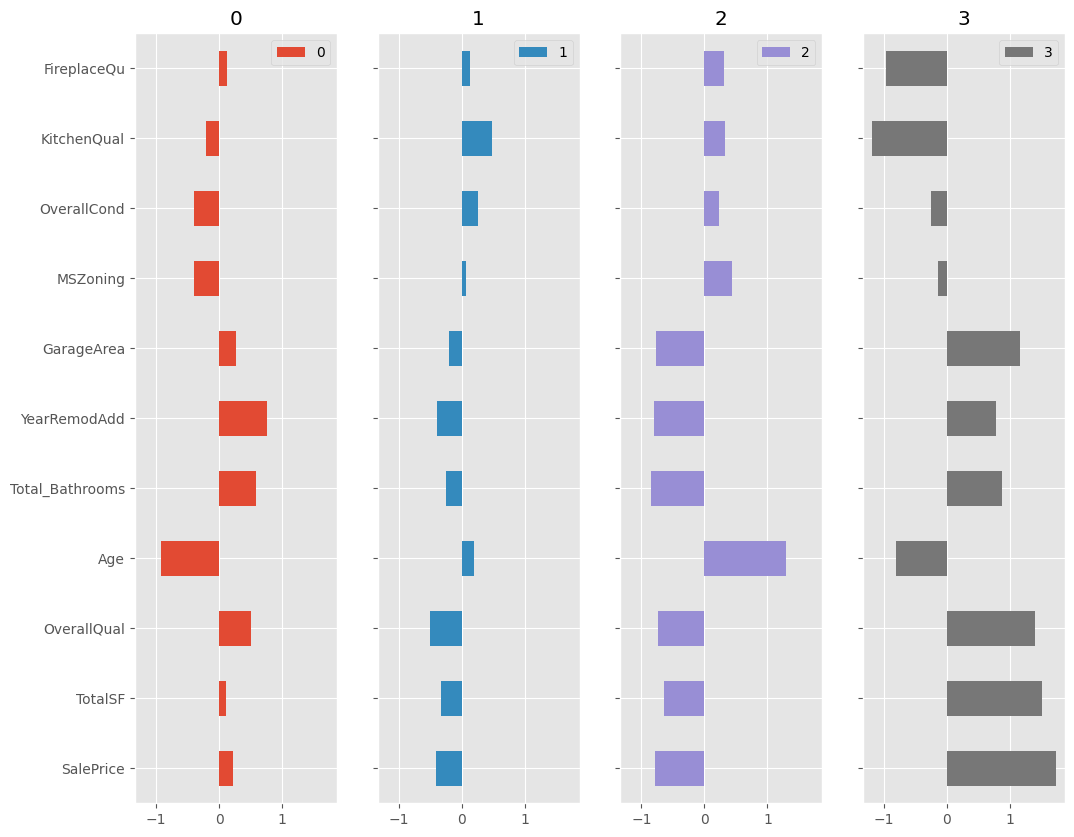

In [100]:
cluster_mean[1:].plot(figsize=(12,10), kind="barh" , subplots=True, layout=(1, 4) , sharey=True)
#클러스터 0 : 오래되고 낡은 주택이지만, 최근 리모델링 중 -> 전체적인 품질은 평균보다 약간 높은 수준
#클러스터 1 : 최근에 지은 주택이지만, 좁고 전체적으로 품질이 낮은 저렴한 주택군
#클러스터 2 : 평균적인 주택군
#클러스터 3 : 오래되고 낡은 주택이지만, 부엌 이외에는 전체적으로 품질이 높고 고가의 주택군

In [101]:
#주성분 분석 - 차원 축소 -> 여러 변수를 대표하는 새로운 변수를 만들어 전체적인 수를 줄이는 방법
#1. 전체 데이터 평균 구함 -> 분산이 커지는 방향을 결정하면 이것이 제1주성분
#2. 제1주성분과 수직인 축을 구하면 이것이 제2주성분이다.
#3. 그 후 가장 가까운 주성분 축에 수직 방향으로 분산이 최대가 되는 축을 구하는 과정을 반복
from sklearn.decomposition import PCA

In [103]:
pca = PCA(n_components=2) #주성분 수 2
house_pca = pca.fit(train_scaled).transform(train_scaled)
house_pca

array([[ 2.64787423, -1.14266229],
       [ 0.59160483, -0.80200928],
       [ 3.272735  , -0.86677223],
       ...,
       [ 1.78389821,  3.57860042],
       [-3.03539315, -0.98944337],
       [-0.66050633, -1.19903916]])

In [104]:
#데이터프레임 형식으로 변환하여 원래 데이터프레임과 결합
house_pca_df = pd.DataFrame(house_pca)
house_pca_df.columns = ["pca1","pca2"]

In [105]:
train_scaled_df = pd.concat([train_scaled_df,house_pca_df], axis=1)

In [106]:
train_scaled_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log,km_cluster,pca1,pca2
0,0.069617,-0.045768,-0.206346,-0.288764,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,0.387825,-0.325762,-1.046470,0.038930,1.736093,0.4596,0.586795,0,2.647874,-1.142662
1,-0.877169,-0.045768,0.512944,-0.075476,0.058926,0.744525,0.310054,-0.026316,-0.634124,-0.222579,...,0.031995,-0.325762,-0.188288,-0.017716,0.640132,0.4596,0.233882,1,0.591605,-0.802009
2,0.069617,-0.045768,-0.062488,0.230544,0.058926,-1.387256,0.310054,-0.026316,0.601627,-0.222579,...,0.585509,-0.325762,-0.980456,0.227753,1.736093,0.4596,0.763584,0,3.272735,-0.866772
3,0.306313,-0.045768,-0.446109,-0.084750,0.058926,-1.387256,0.310054,-0.026316,-1.869875,-0.222579,...,-0.514930,-0.325762,1.792130,-0.086502,-0.455829,0.4596,-0.426767,2,-1.522228,2.171277
4,0.069617,-0.045768,0.704755,0.788800,0.058926,-1.387256,0.310054,-0.026316,-0.634124,-0.222579,...,0.934750,-0.325762,-0.947449,1.086897,1.736093,0.4596,1.048721,3,5.718597,0.948530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.069617,-0.045768,-0.350204,-0.387617,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,-0.053668,-0.325762,-0.947449,0.084787,0.640132,0.4596,0.141076,0,1.340956,-0.240966
1441,-0.877169,-0.045768,0.752707,0.587568,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,0.407594,-0.325762,-0.155281,1.453753,0.640132,0.4596,0.605037,1,1.782666,0.842077
1442,0.306313,-0.045768,-0.158393,-0.178967,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.152202,2.854821,1.065977,1.287858,-0.455829,0.4596,1.211364,0,1.783898,3.578600
1443,-0.877169,-0.045768,-0.062488,-0.053777,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,-0.486925,-0.325762,0.768914,-0.514051,-0.455829,0.4596,-0.388431,1,-3.035393,-0.989443


In [107]:
#주성분 분석 결과 시각화하기 
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] #클러스터 번호로 색상 지정

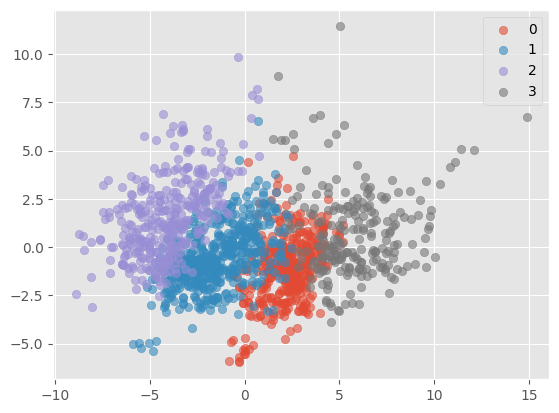

In [108]:
for cl in train_scaled_df['km_cluster'].unique():
    plt.scatter(train_scaled_df.loc[train_scaled_df["km_cluster"] == cl ,'pca1'], train_scaled_df.loc[train_scaled_df["km_cluster"] == cl ,'pca2'], label=cl, c=my_colors[cl], alpha=0.6)
plt.legend()
plt.show()

In [109]:
#제1주성분 및 제2주성분에 어떤 변수가 기여하는지 확인
pca_comp_df = pd.DataFrame(pca.components_,columns=train_scaled_df.drop(["km_cluster","pca1","pca2"],axis=1).columns).T
pca_comp_df.columns = ["pca1","pca2"]

In [110]:
pca_comp_df

,pca1,pca2
MSSubClass,-0.007451,-0.045196
MSZoning,-0.067692,0.062037
LotFrontage,0.089335,0.138845
LotArea,0.084628,0.168662
Street,0.010013,0.010766
...,...,...
Age,-0.197903,0.246228
TotalSF,0.218012,0.188238
Total_Bathrooms,0.189083,0.029216
hasPorch,0.091475,0.031052


# 결과
k-means나 주성분 분석을 이용하여 클러스터 분석을 실시해 데이터 전체 경향 파악 가능

실제 작업에서는 클러스터별로 측정값을 변경할 수 있으며, 클러스터별 목표 달성률을 확인할 수 있다.

<hr>

# 추가 분석2 - 고급 주택의 조건을 분석하고 시각화

<AxesSubplot: ylabel='Frequency'>

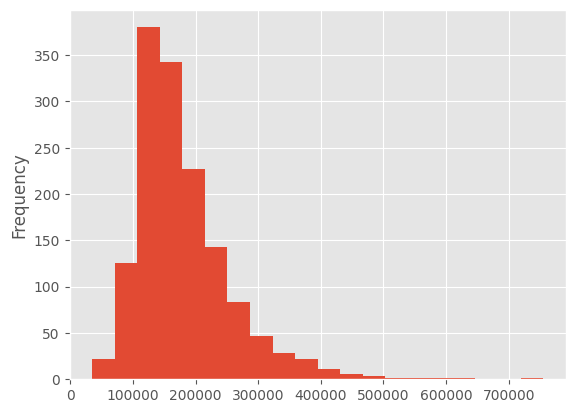

In [111]:
#결정 트리로 시각화
train_df_le['SalePrice'].plot.hist(bins=20) #SalePrice 분포 확인

In [112]:
train_df_le['SalePrice'].describe()

count      1445.000000
mean     179072.294118
std       75905.045476
min       34900.000000
25%      129900.000000
50%      162000.000000
75%      213000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [113]:
#상위 10%의 가격 조사
train_df['SalePrice'].quantile(0.9)

278000.0

In [114]:
#고급 주택 변수 추가하기
train_df_le.loc[train_df["SalePrice"]>=278000, "high_class"]=1

In [115]:
train_df_le["high_class"] = train_df_le["high_class"].fillna(0)

In [116]:
train_df_le.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log,high_class
0,1,60,3,65.0,8450,1,3,3,0,4,...,8,4,208500.0,0,5,2566.0,4.0,1,12.247694,0.0
1,2,20,3,80.0,9600,1,3,3,0,2,...,8,4,181500.0,0,31,2524.0,3.0,1,12.109011,0.0
2,3,60,3,68.0,11250,1,0,3,0,4,...,8,4,223500.0,0,7,2706.0,4.0,1,12.317167,0.0
3,4,70,3,60.0,9550,1,0,3,0,0,...,8,0,140000.0,0,91,2473.0,2.0,1,11.849398,0.0
4,5,60,3,84.0,14260,1,0,3,0,2,...,8,4,250000.0,0,8,3343.0,4.0,1,12.429216,0.0


In [117]:
!pip install pydotplus==2.0.2

     -------------------------------------- 278.7/278.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24554 sha256=5c6fd0fc414c3b932867cc13468d2d0f001391f593642c615d9719608135dfae
  Stored in directory: c:\users\lwg\appdata\local\pip\cache\wheels\69\b2\67\08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [118]:
!pip install graphviz==0.14.1


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [121]:
!pip install six==1.15.0


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [132]:
from sklearn import tree
import pydotplus
from six import StringIO
#중요도가 높은 변수로 압축하기 - LightGBM을 이용하여 중요도가 높이 나온 것 이용
tree_x = train_df_le[["TotalSF","OverallQual","Age","GrLivArea","GarageCars","Total_Bathrooms","GarageType",
"YearRemodAdd","GarageArea","CentralAir","MSZoning","OverallCond","KitchenQual","FireplaceQu","1stFlrSF"]]
tree_y = train_df_le[["high_class"]]

In [133]:
#깊이를 지정하여 결정 트리 작성
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(tree_x, tree_y)

In [134]:
#결정 트리의 출력 결과 확인하기
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,feature_names=tree_x.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [135]:
from IPython.display import Image
Image(graph.create_png())

InvocationException: GraphViz's executables not found

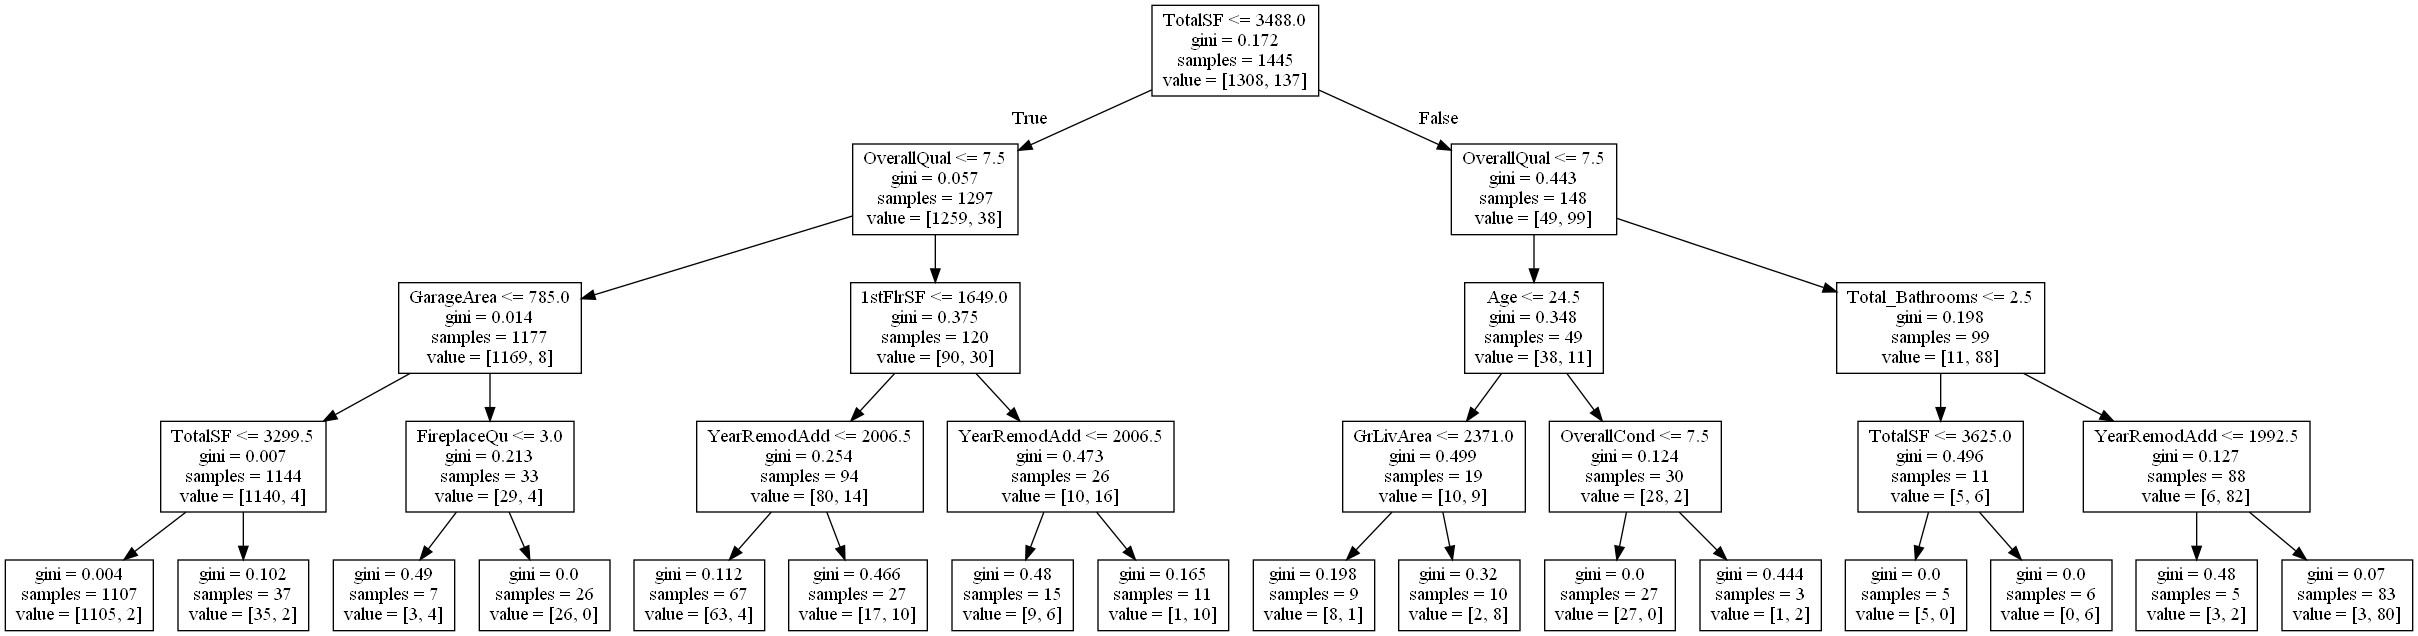
# 결과
고급 주택 조건은 TotalSF 3489 이상, OverallQual 8 이상, GrLivArea 1814 이상, YearRemodAdd 1993이상 이거나

OverallQual 8 이상, 1stFlrSF 1650 이상, YearRemodAdd가 2007 이상

-> LightGBM 보다 정확도가 떨어지고 에측 작업에서 결정 트리를 사용할 일이 거의 없다.